In [1]:
import cv2
import skimage
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
import pylab
import pandas as pd


First thing we want to define is a function which will give as output the cropped images. To do so we define two functions crop_rect & cropimag the first one is very helpful to rotate the images, the second one is useful to find the contour of the images and crop them.

In [2]:
 
def crop_rect(img, rect):
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]

    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv2.warpAffine(img, M, (width, height))

    # now rotated rectangle becomes vertical, and we crop it
    img_crop = cv2.getRectSubPix(img_rot, size, center)

    return img_crop, img_rot
        

In [3]:
def cropimag (path,cropped_path):
# Set the path 
    cropped_images = []
    # Creation of a new folder for cropped photos
    if not os.path.exists(cropped_path):
        os.makedirs(cropped_path)

# Iterate over all the images in the folder
    for filename in os.listdir(path):
       if filename.endswith(".jpg") or filename.endswith(".bmp") :  # Verify that the file is an image      
        # Load the image
            img = cv2.imread(os.path.join(path, filename),)
       
        # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred_img = cv2.bilateralFilter(gray, 10, 100, 100) #3,80,80 #10,100,100
        # Otsu binarization
            (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
     

        # Apply the Canny filter to detect edges
            edged = cv2.Canny(threshInv, 30, 200)

        # Find the contours
            contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

        # Select only the four biggest contour (it takes 2 per image for this reason there is [:8]
            largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:8]

        # crop the pictures following the four biggest contours
            for i, contours in enumerate (largest_contours):
                if i % 2 == 0:
                    rect = cv2.minAreaRect(contours)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)
                    cropped_image, rot_image = crop_rect(img, rect)
                    cropped_images.append(cropped_image)                
                    cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

        #save the cropped images
                cv2.imwrite(os.path.join(cropped_path, cropped_filename), cropped_image) 

So once we developed the code we can run it, now we noticed that some images presentes a number inferior to 4 of pieces. Considering the fact that our code take the 1st four largest contour it crops also two part that are not pieces. To avoid that those elements infer to our run chart, we define a new function to remove all the possible images that may differ.

In [4]:
def deletephotos(cartella, peso):
    for nome_file in os.listdir(cartella):
        percorso_file = os.path.join(cartella, nome_file)
        if os.path.isfile(percorso_file):
            dimensione = os.path.getsize(percorso_file)
            if dimensione < peso:
                os.remove(percorso_file)
                print(f"Foto eliminata: {percorso_file}")

Now it is important to find a way to binarize the picture to find a method to build our SPC. To do so the first methodology we thought is to count the pixels. 
So we defined also a function to do it.

In [5]:
#BINARIZE CROPPED PICTURES 
def binimage(path, cropped_path, bin_path):
    if not os.path.exists(bin_path):
        os.makedirs(bin_path)
    for filename in os.listdir(cropped_path):
        img = cv2.imread(os.path.join(cropped_path, filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Blur the image
        blurred_img = cv2.bilateralFilter(gray, 4, 25, 1) #4,20,1
        (T, threshInv) = cv2.threshold(blurred_img, 45, 255,cv2.THRESH_BINARY)
        bin_filename = os.path.splitext(filename)[0] + "_bin.jpg"
        cv2.imwrite(os.path.join(bin_path, bin_filename), threshInv)


In [6]:

def Findbiggestblackarea(image_path):
    # Load the binarized image in grayscale
    image = cv2.imread(image_path, 0)

    # Find the contours of the binarized image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours based on area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # If there are at least two contours, display the image with the second contour highlighted
    if len(contours) >= 2:
        second_contour = contours[1]
        second_area = cv2.contourArea(second_contour)

        # Draw the contour on the image
        #image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        #cv2.drawContours(image_color, [second_contour], 0, (0, 0, 255), 2)

        # It shows the image with the largest contour.
        #cv2.imshow("Immagine con secondo contorno", image_color)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

        return second_area

    # If no enough contours, return 0
    return 0

In [8]:
cropimag("acquisition\sane",os.path.join("acquisition\sane","cropped"))

In [13]:

deletephotos(r'C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped', 18000)

Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped\test (1)_crp3.jpg
Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped\test (1)_crp5.jpg
Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped\test (1)_crp7.jpg
Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped\test (10)_crp3.jpg
Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped\test (10)_crp5.jpg
Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped\test (10)_crp7.jpg
Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped\test (11)_crp3.jpg
Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped\test (11)_crp5.jpg
Foto eliminata: C:\Users\feder\Documents\FEDE\UNIVERSITA\FO

In [10]:

binimage("acquisition\sane",r"C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\sane\cropped","acquisition\sane/binarized")


In [11]:
cropimag("acquisition\TEST",os.path.join("acquisition\TEST","cropped"))

In [14]:
binimage("acquisition\TEST",r"C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\cropped","acquisition\TEST/binarized")

Once phase 1 is over we can start the 2nd phase. We import the data that we want to control and we stick them in the already existing control chart.

+ NEW METHODOLOGY: we are going to consider the area of the biggest circle.

To pursue our goal we considered a sample with size 1, where the single pieces represent a single observation.

## PERIMETER


In [15]:
Folderimages = r'C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\sane\binarized'
pmm = []
for nameimg in os.listdir(Folderimages):
    pathimg = os.path.join(Folderimages, nameimg)
    image = cv2.imread(pathimg, cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(image, (17, 17), 1)
    # Find the contours of the black areas
    contours, _ = cv2.findContours(blurred_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_KCOS )

    # Find the area with the largest perimeter in the current image
    max_perimeter = 0
    max_contour = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        if perimeter > max_perimeter:
            max_perimeter = perimeter
            max_contour = contour
    pmm.append(max_perimeter)

  
    # Stampa il perimetro dell'area con il perimetro maggiore
    #print("Perimetro dell'area con il perimetro maggiore nell'immagine", nameimg, ":", max_perimeter)


PERIMETER BROKEN


In [27]:
Folderimages = r'C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\binarized'
pmmD = []
for nameimg in os.listdir(Folderimages):
    pathimg = os.path.join(Folderimages, nameimg)
    image = cv2.imread(pathimg, cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(image, (17, 17), 1)
    # Find the contours of the black areas
    contours, _ = cv2.findContours(blurred_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_KCOS )

    # Find the area with the largest perimeter in the current image
    max_perimeter = 0
    max_contour = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        if perimeter > max_perimeter:
            max_perimeter = perimeter
            max_contour = contour
    pmmD.append(max_perimeter)

  
    # Stampa il perimetro dell'area con il perimetro maggiore
    #print("Perimetro dell'area con il perimetro maggiore nell'immagine", nome_immagine, ":", max_perimeter)
#print (pmmD)

In [28]:
print(pmmD)

[941.1379828453064, 956.5062222480774, 1032.7869226932526, 1008.2562445402145, 1016.5723785161972, 915.8921720981598, 916.1028101444244, 928.5972656011581, 927.2022686004639, 909.1385941505432, 924.8174687623978, 922.7304439544678, 926.1073960065842, 927.1901942491531, 908.9458174705505, 923.5183104276657, 920.5430512428284, 926.5049246549606, 928.6449760198593, 924.2930543422699, 954.7626559734344, 1004.8074659109116, 971.1149376630783, 926.4339555501938, 962.8428550958633, 951.7597655057907, 965.8321353197098, 958.9396691322327]


## AREE NERE SANE

In [17]:
folder_path = r"C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\sane\binarized"

# List to save the values of the larger black areas
aree_nere_maggiori = []

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Costruisci il percorso completo dell'immagine
        image_path = os.path.join(folder_path, filename)
        
        # Find the biggest area for the image
        area_nera_maggiore = Findbiggestblackarea(image_path)
        
        # Aggiungi l'area nera maggiore alla lista
        aree_nere_maggiori.append(area_nera_maggiore)

AREE NERE ROTTE

In [22]:
#Same code for broken pieces.
folder_path1 = r"C:\Users\feder\Documents\FEDE\UNIVERSITA\FOOD\QDA\PROJECT\acquisition\TEST\binarized"
AreeNMD = []

for filename in os.listdir(folder_path1):
    if filename.endswith(".jpg") or filename.endswith(".png"):
       
        image_path = os.path.join(folder_path1, filename)
        AreaNMD = Findbiggestblackarea(image_path)
        AreeNMD.append(AreaNMD)


In [20]:
print('areas')

areas


In [29]:
#Creating a DataFrame for DEFECTS
DEFECT = pd.DataFrame()
DEFECT['per'] = pmmD
DEFECT['areas'] = AreeNMD
DEFECT.to_csv('DEFECT.csv', index=False)
DEFECT.head()

,per,areas
0,941.137983,522.5
1,956.506222,560.0
2,1032.786923,531.0
3,1008.256245,552.0
4,1016.572379,550.0


In [21]:
#Creating a DataFrame for PHASE 1
DESIGN = pd.DataFrame()
DESIGN['per'] = pmm
DESIGN['areas'] = aree_nere_maggiori
DESIGN.to_csv('DESIGN.csv', index=False)
DESIGN.head()

,per,areas
0,909.220206,522.0
1,913.793338,557.0
2,924.171771,539.5
3,914.541334,503.0
4,917.459661,548.0


## aree nere, runs test and normality

In [30]:
aree_des=DESIGN['areas']

Shapiro-Wilk test on Width p-value = 0.715


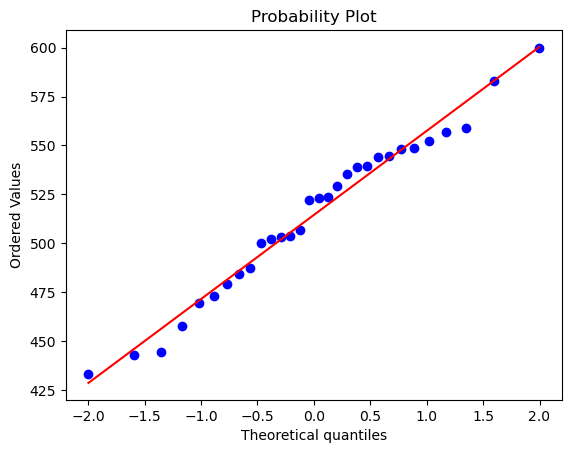

In [31]:
# Perform the Shapiro-Wilk test on the Width
_, pval1_SW = stats.shapiro(aree_des)
print('Shapiro-Wilk test on Width p-value = %.3f' % pval1_SW)

# Plot the qqplot
stats.probplot(aree_nere_maggiori, dist="norm", plot=plt)
plt.show()

0.06550993456550351


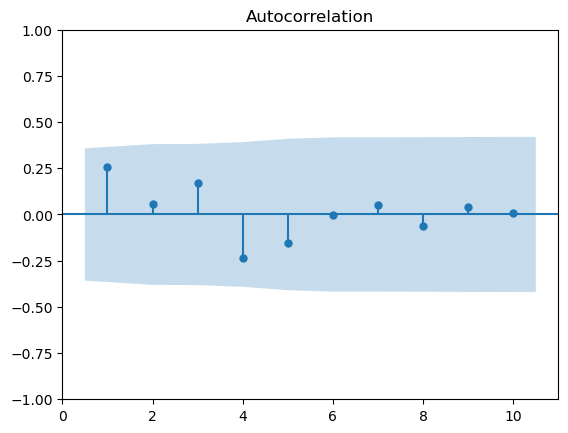

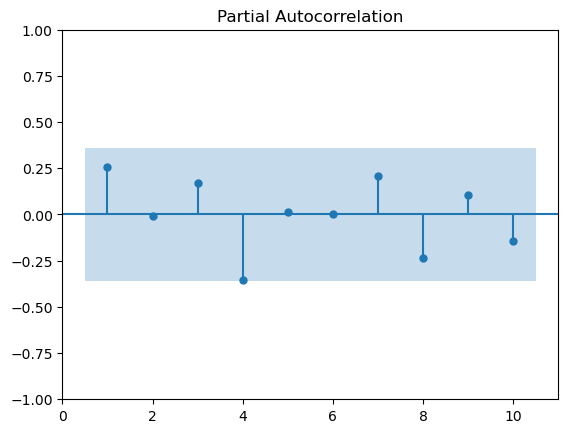

In [32]:
#RUN'S TEST
from statsmodels.sandbox.stats.runs import runstest_1samp
stat, pval_runs = runstest_1samp(aree_des, correction=False)  
print(pval_runs)

import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(aree_des, lags = int(len(aree_des)/3), zero=False) 
plt.show()
sgt.plot_pacf(aree_des, lags = int(len(aree_des)/3), zero=False,  method = 'ywm') 
plt.show()

PERIMETRI RUN'S TEST E QQPLOT

In [33]:
per_des=DESIGN['per']

Shapiro-Wilk test on Width p-value = 0.316


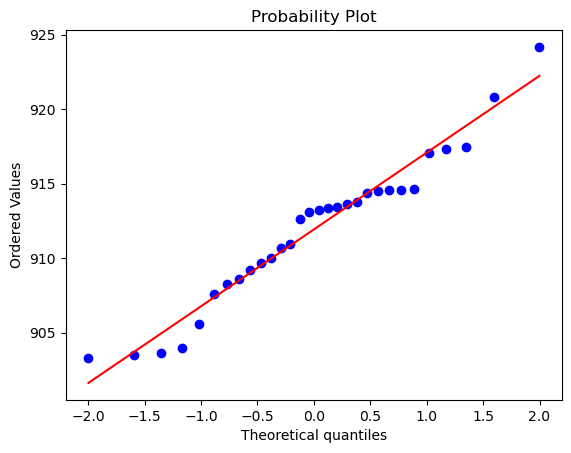

In [34]:
# Perform the Shapiro-Wilk test on the Width
_, pval1_SW = stats.shapiro(per_des)
print('Shapiro-Wilk test on Width p-value = %.3f' % pval1_SW)

# Plot the qqplot
stats.probplot(per_des, dist="norm", plot=plt)
plt.show()

0.511689253168283


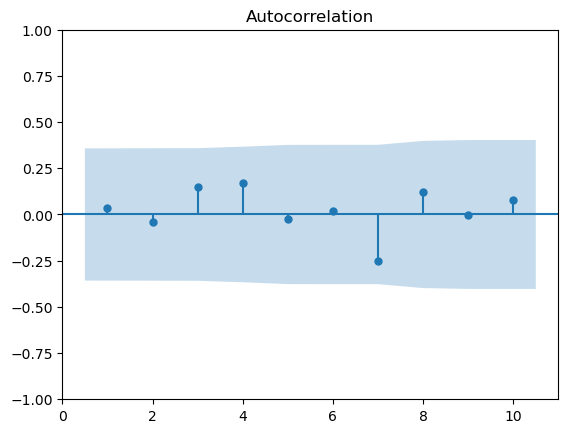

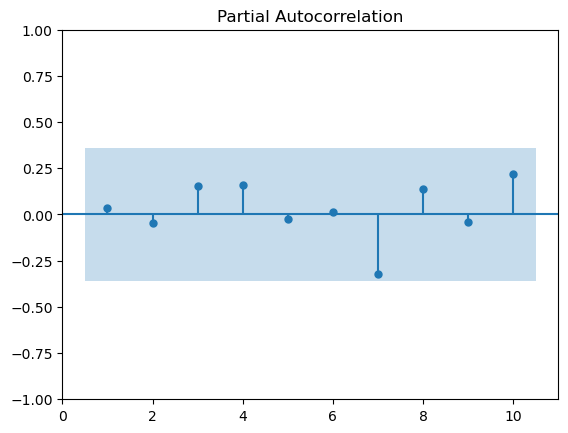

In [35]:
#RUN'S TEST
from statsmodels.sandbox.stats.runs import runstest_1samp
stat, pval_runs = runstest_1samp(per_des, correction=False)  
print(pval_runs)

import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(per_des, lags = int(len(per_des)/3), zero=False) 
plt.show()
sgt.plot_pacf(per_des, lags = int(len(per_des)/3), zero=False,  method = 'ywm') 
plt.show()

In [36]:
# We set our alpha
p = 2 #number of variables
alpha = 0.0027/p
K=stats.norm.ppf(1-alpha/2)
d2=1.128
D4=3.267

In [37]:
DESIGN=pd.read_csv("DESIGN.csv") 
DEFECT=pd.read_csv("DEFECT.csv") 

In [38]:
# we create a Moving Range column
DESIGN['MRA'] = DESIGN['areas'].diff().abs()
DESIGN['MRP'] = DESIGN['per'].diff().abs()
DESIGN.head()

,per,areas,MRA,MRP
0,909.220206,522.0,NaN,NaN
1,913.793338,557.0,35.0,4.573132
2,924.171771,539.5,17.5,10.378433
3,914.541334,503.0,36.5,9.630437
4,917.459661,548.0,45.0,2.918328


In [39]:
# Define columns for possible violations of the control limits for areas
DESIGN['I_UCLA'] = DESIGN['areas'].mean() + (K*DESIGN['MRA'].mean()/d2)
DESIGN['I_CLA'] = DESIGN['areas'].mean()
DESIGN['I_LCLA'] = DESIGN['areas'].mean() - (K*DESIGN['MRA'].mean()/d2)
DESIGN['MR_UCLA'] = D4 * DESIGN['MRA'].mean()
DESIGN['MR_CLA'] = DESIGN['MRA'].mean()
DESIGN['MR_LCLA'] = 0

DESIGN['I_TEST_A'] = np.where((DESIGN['areas'] > DESIGN['I_UCLA']) | 
                ((DESIGN['areas'] < DESIGN['I_LCLA'])), DESIGN['areas'], np.nan)
DESIGN['MR_TEST1'] = np.where((DESIGN['MR_CLA'] > DESIGN['MR_UCLA']) | 
                (DESIGN['MR_CLA'] < DESIGN['MR_LCLA']), DESIGN['MR_CLA'], np.nan)
DESIGN

,per,areas,MRA,MRP,I_UCLA,I_CLA,I_LCLA,MR_UCLA,MR_CLA,MR_LCLA,I_TEST_A,MR_TEST1
0,909.220206,522.0,NaN,NaN,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
1,913.793338,557.0,35.0,4.573132,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
2,924.171771,539.5,17.5,10.378433,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
3,914.541334,503.0,36.5,9.630437,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
4,917.459661,548.0,45.0,2.918328,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
5,913.660919,506.5,41.5,3.798742,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
6,912.598334,479.0,27.5,1.062585,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
7,913.433960,529.0,50.0,0.835626,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
8,913.261545,523.5,5.5,0.172415,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN
9,903.332433,539.0,15.5,9.929112,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN


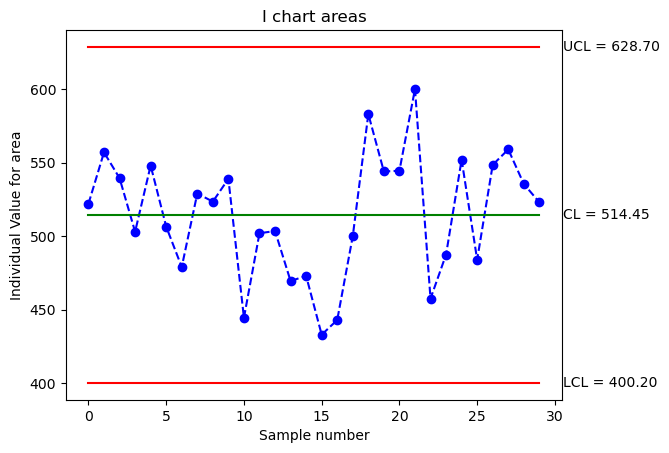

In [40]:
# Plot the I chart for areas
plt.title('I chart areas')
plt.plot(DESIGN['areas'], color='b', linestyle='--', marker='o')
plt.plot(DESIGN['I_UCLA'], color='r')
plt.plot(DESIGN['I_CLA'], color='g')
plt.plot(DESIGN['I_LCLA'], color='r')
plt.ylabel('Individual Value for area')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(DESIGN)+.5, DESIGN['I_UCLA'].iloc[0], 'UCL = {:.2f}'.format(DESIGN['I_UCLA'].iloc[0]), verticalalignment='center')
plt.text(len(DESIGN)+.5, DESIGN['I_CLA'].iloc[0], 'CL = {:.2f}'.format(DESIGN['I_CLA'].iloc[0]), verticalalignment='center')
plt.text(len(DESIGN)+.5, DESIGN['I_LCLA'].iloc[0], 'LCL = {:.2f}'.format(DESIGN['I_LCLA'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(DESIGN['I_TEST_A'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In [41]:
# Define columns for possible violations of the control limits for perimeters
DESIGN['I_UCLP'] = DESIGN['per'].mean() + (K*DESIGN['MRP'].mean()/d2)
DESIGN['I_CLP'] = DESIGN['per'].mean()
DESIGN['I_LCLP'] = DESIGN['per'].mean() - (K*DESIGN['MRP'].mean()/d2)
DESIGN['MR_UCLP'] = D4 * DESIGN['MRP'].mean()
DESIGN['MR_CLP'] = DESIGN['MRP'].mean()
DESIGN['MR_LCLP'] = 0

DESIGN['I_TESTP'] = np.where((DESIGN['per'] > DESIGN['I_UCLP']) | 
                ((DESIGN['per'] < DESIGN['I_LCLP'])), DESIGN['per'], np.nan)
DESIGN['MR_TESTP'] = np.where((DESIGN['MRP'] > DESIGN['MR_UCLP']) | 
                (DESIGN['MRP'] < DESIGN['MR_LCLP']), DESIGN['MRP'], np.nan)
DESIGN

,per,areas,MRA,MRP,I_UCLA,I_CLA,I_LCLA,MR_UCLA,MR_CLA,MR_LCLA,I_TEST_A,MR_TEST1,I_UCLP,I_CLP,I_LCLP,MR_UCLP,MR_CLP,MR_LCLP,I_TESTP,MR_TESTP
0,909.220206,522.0,NaN,NaN,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
1,913.793338,557.0,35.0,4.573132,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
2,924.171771,539.5,17.5,10.378433,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
3,914.541334,503.0,36.5,9.630437,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
4,917.459661,548.0,45.0,2.918328,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
5,913.660919,506.5,41.5,3.798742,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
6,912.598334,479.0,27.5,1.062585,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
7,913.433960,529.0,50.0,0.835626,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
8,913.261545,523.5,5.5,0.172415,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN
9,903.332433,539.0,15.5,9.929112,628.695087,514.45,400.204913,131.355931,40.206897,0,NaN,NaN,928.124697,911.929708,895.734719,18.620563,5.699591,0,NaN,NaN


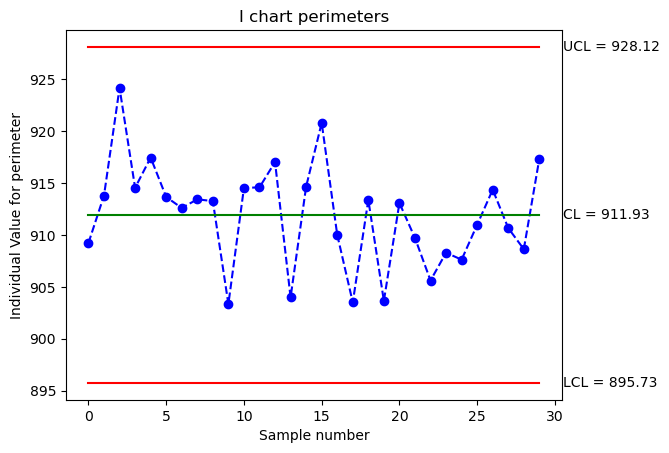

In [42]:
# Plot the I chart for per
plt.title('I chart perimeters')
plt.plot(DESIGN['per'], color='b', linestyle='--', marker='o')
plt.plot(DESIGN['I_UCLP'], color='r')
plt.plot(DESIGN['I_CLP'], color='g')
plt.plot(DESIGN['I_LCLP'], color='r')
plt.ylabel('Individual Value for perimeter')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(DESIGN)+.5, DESIGN['I_UCLP'].iloc[0], 'UCL = {:.2f}'.format(DESIGN['I_UCLP'].iloc[0]), verticalalignment='center')
plt.text(len(DESIGN)+.5, DESIGN['I_CLP'].iloc[0], 'CL = {:.2f}'.format(DESIGN['I_CLP'].iloc[0]), verticalalignment='center')
plt.text(len(DESIGN)+.5, DESIGN['I_LCLP'].iloc[0], 'LCL = {:.2f}'.format(DESIGN['I_LCLP'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(DESIGN['I_TESTP'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In [43]:
DEFECT['I_UCLP'] = DESIGN['per'].mean() + (K*DESIGN['MRP'].mean()/d2)
DEFECT['I_LCLP'] = DESIGN['per'].mean() - (K*DESIGN['MRP'].mean()/d2)
DEFECT['I_TESTP'] = np.where((DEFECT['per'] > DEFECT['I_UCLP']) | 
                ((DEFECT['per'] < DEFECT['I_LCLP'])), DEFECT['per'], np.nan)

In [44]:
DEFECT['I_UCLA'] = DESIGN['areas'].mean() + (K*DESIGN['MRA'].mean()/d2)
DEFECT['I_LCLA'] = DESIGN['areas'].mean() - (K*DESIGN['MRA'].mean()/d2)
DEFECT['I_TEST_A'] = np.where((DEFECT['areas'] > DEFECT['I_UCLA']) | 
                ((DEFECT['areas'] < DEFECT['I_LCLA'])), DEFECT['areas'], np.nan)

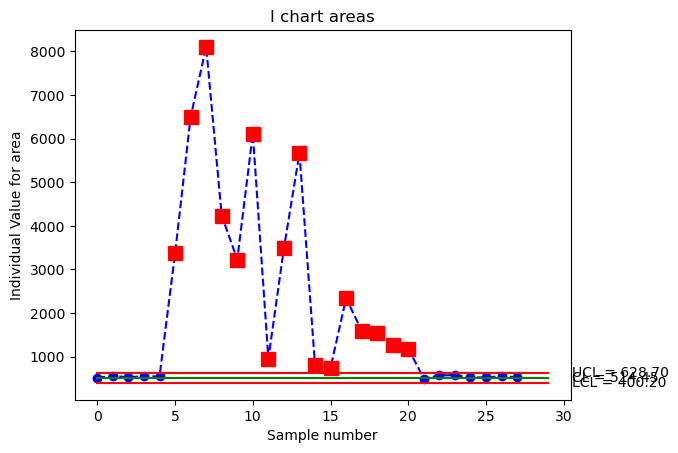

In [45]:
# Plot the I chart for areas
plt.title('I chart areas')
plt.plot(DEFECT['areas'], color='b', linestyle='--', marker='o')
plt.plot(DESIGN['I_UCLA'], color='r')
plt.plot(DESIGN['I_CLA'], color='g')
plt.plot(DESIGN['I_LCLA'], color='r')
plt.ylabel('Individual Value for area')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(DESIGN)+.5, DESIGN['I_UCLA'].iloc[0], 'UCL = {:.2f}'.format(DESIGN['I_UCLA'].iloc[0]), verticalalignment='center')
plt.text(len(DESIGN)+.5, DESIGN['I_CLA'].iloc[0], 'CL = {:.2f}'.format(DESIGN['I_CLA'].iloc[0]), verticalalignment='center')
plt.text(len(DESIGN)+.5, DESIGN['I_LCLA'].iloc[0], 'LCL = {:.2f}'.format(DESIGN['I_LCLA'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(DEFECT['I_TEST_A'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

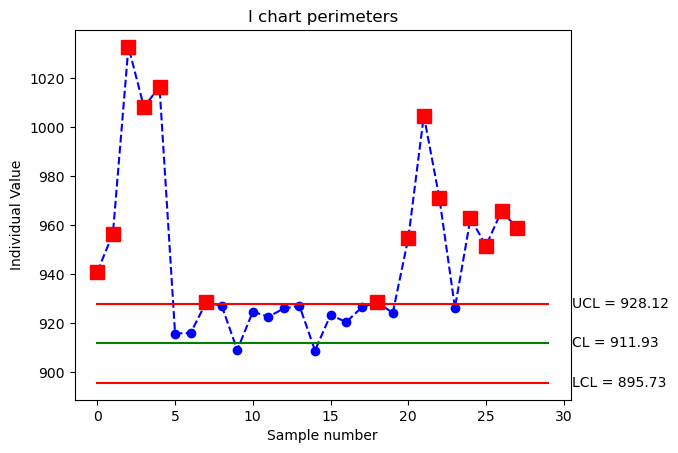

In [46]:
# Plot the I chart for per
plt.title('I chart perimeters')
plt.plot(DEFECT['per'], color='b', linestyle='--', marker='o')
plt.plot(DESIGN['I_UCLP'], color='r')
plt.plot(DESIGN['I_CLP'], color='g')
plt.plot(DESIGN['I_LCLP'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(DESIGN)+.5, DESIGN['I_UCLP'].iloc[0], 'UCL = {:.2f}'.format(DESIGN['I_UCLP'].iloc[0]), verticalalignment='center')
plt.text(len(DESIGN)+.5, DESIGN['I_CLP'].iloc[0], 'CL = {:.2f}'.format(DESIGN['I_CLP'].iloc[0]), verticalalignment='center')
plt.text(len(DESIGN)+.5, DESIGN['I_LCLP'].iloc[0], 'LCL = {:.2f}'.format(DESIGN['I_LCLP'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(DEFECT['I_TESTP'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In [188]:
# Elimina la colonna desiderata
#DEFECT = DEFECT.drop("I_UCLP", axis=1)
#DEFECT = DEFECT.drop("I_LCLP", axis=1)
#DEFECT = DEFECT.drop("I_UCLA", axis=1)
#DEFECT = DEFECT.drop("I_LCLA", axis=1)
#DEFECT = DEFECT.drop("outlier_a", axis=1)


In [47]:
DEFECT

,per,areas,I_UCLP,I_LCLP,I_TESTP,I_UCLA,I_LCLA,I_TEST_A
0,941.137983,522.5,928.124697,895.734719,941.137983,628.695087,400.204913,NaN
1,956.506222,560.0,928.124697,895.734719,956.506222,628.695087,400.204913,NaN
2,1032.786923,531.0,928.124697,895.734719,1032.786923,628.695087,400.204913,NaN
3,1008.256245,552.0,928.124697,895.734719,1008.256245,628.695087,400.204913,NaN
4,1016.572379,550.0,928.124697,895.734719,1016.572379,628.695087,400.204913,NaN
5,915.892172,3367.0,928.124697,895.734719,NaN,628.695087,400.204913,3367.0
6,916.102810,6493.5,928.124697,895.734719,NaN,628.695087,400.204913,6493.5
7,928.597266,8098.5,928.124697,895.734719,928.597266,628.695087,400.204913,8098.5
8,927.202269,4234.5,928.124697,895.734719,NaN,628.695087,400.204913,4234.5
9,909.138594,3227.5,928.124697,895.734719,NaN,628.695087,400.204913,3227.5


QUA SOTTO NON HO CAPITO BENE COSA SIA. PER GLI MR CHART SI PUò USARE qda FORSE che maagri rende più facile


NameError: name 'm' is not defined

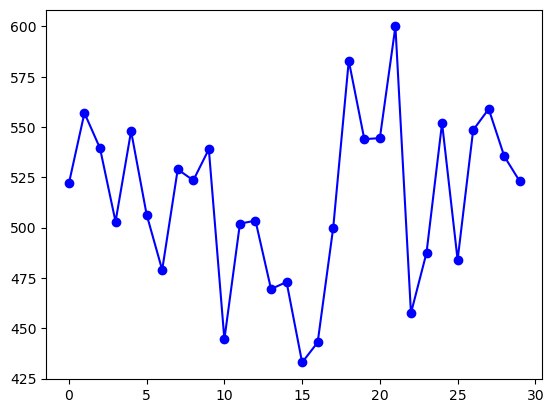

In [49]:
plt.plot( aree_des, marker='o', linestyle='-', color='b')
plt.axhline(y=m, color='r', linestyle='--', label='Mean')
plt.axhline(y=UCL_x1, color='g', linestyle='--', label='UCL')
plt.axhline(y=LCL_x1, color='g', linestyle='--', label='LCL')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Data')
plt.title('MR CHART')
plt.show()

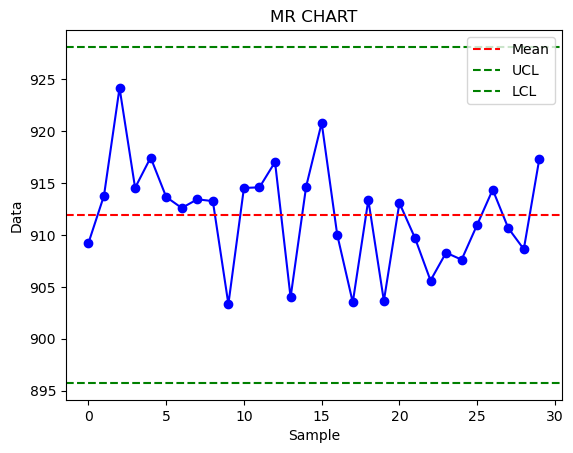

In [50]:
mu_cap=np.mean(per_des)
MR=[]
for i in range(1, len(per_des)):
    
        diff=abs(per_des[i]-per_des[i-1])
        MR.append(diff)

MR_mean=np.mean(MR)
UCL_x1=mu_cap+3.205*MR_mean/1.128
LCL_x1=mu_cap-3.205*MR_mean/1.128
m=mu_cap

plt.plot( per_des, marker='o', linestyle='-', color='b')
plt.axhline(y=m, color='r', linestyle='--', label='Mean')
plt.axhline(y=UCL_x1, color='g', linestyle='--', label='UCL')
plt.axhline(y=LCL_x1, color='g', linestyle='--', label='LCL')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Data')
plt.title('MR CHART')
plt.show()

In [51]:
per_def=DEFECT['per']

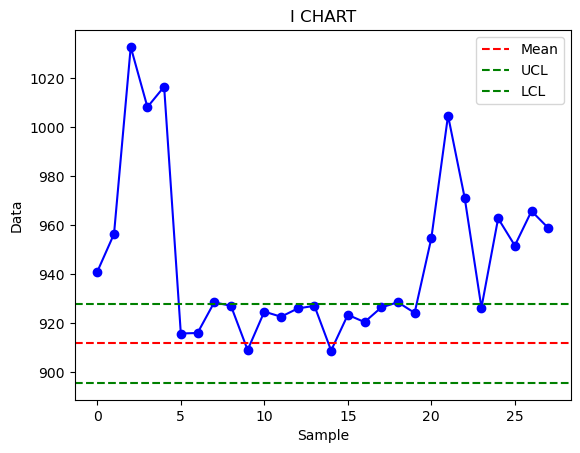

In [52]:
plt.plot( per_def, marker='o', linestyle='-', color='b')
plt.axhline(y=m, color='r', linestyle='--', label='Mean')
plt.axhline(y=UCL_x1, color='g', linestyle='--', label='UCL')
plt.axhline(y=LCL_x1, color='g', linestyle='--', label='LCL')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Data')
plt.title('I CHART')
plt.show()

In [53]:
import qda
d2 = qda.constants.getd2(2)
D4 = qda.constants.getD4(2)
ucl = D4*MR_mean
cl = MR_mean
lcl = 0


ModuleNotFoundError: No module named 'qda'

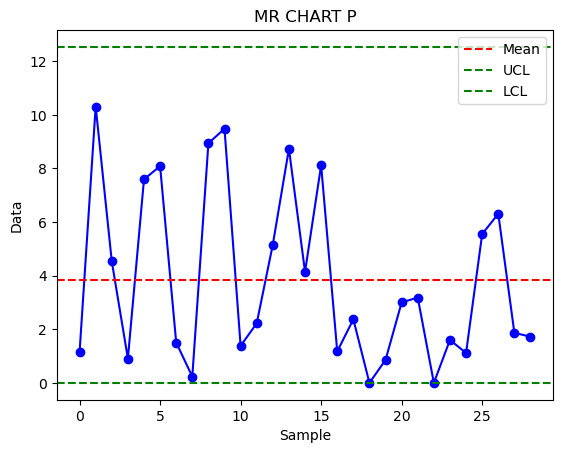

In [ ]:
plt.plot( MR, marker='o', linestyle='-', color='b')
plt.axhline(y=cl, color='r', linestyle='--', label='Mean')
plt.axhline(y=ucl, color='g', linestyle='--', label='UCL')
plt.axhline(y=lcl, color='g', linestyle='--', label='LCL')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Data')
plt.title('MR CHART P')
plt.show()

In [54]:
MRD = []
for i in range(1, len(pmmD)):
    
        diff2=abs(pmmD[i]-pmmD[i-1])
        MRD.append(diff2)
        

NameError: name 'cl' is not defined

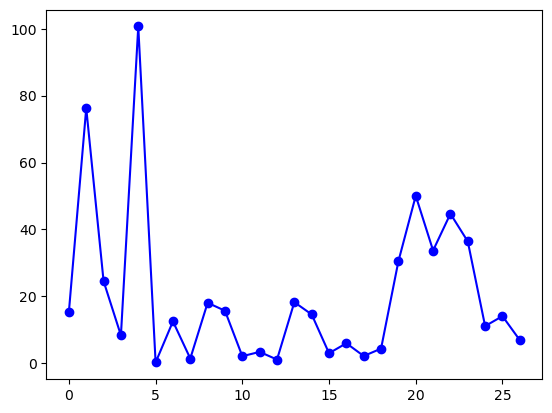

In [55]:
plt.plot( MRD, marker='o', linestyle='-', color='b')
plt.axhline(y=cl, color='r', linestyle='--', label='Mean')
plt.axhline(y=ucl, color='g', linestyle='--', label='UCL')
plt.axhline(y=lcl, color='g', linestyle='--', label='LCL')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Data')
plt.title('MR CHART')
plt.show()